# Homework 3. Models validation 

<a id='Homework'></a>
## Homework

**Theory** (5 points):

>Follow **Explore** and **TODO** sections.  
>Answer theory questions in the Google Form.
>List of questions:
> - A model has high accuracy (e.g. 95%) but low precision (e.g. 10%) and recall (e.g. 10%) on the positive class in a binary classification problem. What could be happening and should we describe this kind of performance as "rather good, because the accuracy is high" or "rather bad, because the precision/recall/f1 is low"?
> - Describe cases (or provide examples) in which in a multiclass classification problem the values of F1 macro will be greater than F1 micro and vice versa? What do you think happens more often in practice and why?
> - Imagine that you are in production developing a similar system for Twitter for identifying real disasters, think about whether the split proposed in the kaggle competition (random, possibly with stratification by target) is optimal for a production model validation (assume that you have all the possible necessary data here) and if you think it could be not optimal - describe your ideas?
> - For the task of recognizing disasters from tweets and quickly reacting to them by the relevant government authorities, describe cases or pipelines for processing suspected disasters for which a precision-optimized model would be more useful, and for which a recall-optimized one?
> - For a task similar to the one proposed above (commonlit-evaluate-student-summaries) regression for both targets with the same input tables structure (assume that the uniqueness/non-uniqueness of ids fields corresponds to the proposed here problem statement), propose and describe validation strategies in such cases (in writing):<br>
> A) Case in which we want to evaluate other students on the same questions (prompt text + prompt question); <br>
> B) Case in which we want to evaluate the same students on different (unseen) questions (prompt text + prompt question); <br>
> C) Case in which we want to evaluate other (unseen) students on different (unseen) questions (prompt text + prompt question)

**Practice** (10 points):
 
> 1. Check local validation vs public leaderboard metrics consistency for your models for [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview) and implement adversarial validation (train vs public test) to be shure that there is no features shift in the test dataset.<br>
> 2. For the [CommonLit - Evaluate Student Summaries](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/) task and dataset your aim is to configure a proper validation. Modeling itself is not the case here, what is more important here is the implementation of the validation mechanics. Try the following:
> - Read some public [discussions](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion?sort=published) that are relevant to the validation topic.
> - Try regular K-fold cross-validation (optionally stratified by prompt_id) and check whether your local validation matches the LB in terms of correlations of metrics increases between experiments and in terms of absolute values match.
> - Try Group K-fold cross-validation (groupped by prompt_id) and check whether your local validation matches the LB in terms of correlations of metrics increases between experiments and in terms of absolute values match.
> - Describe your thoughts about local validation vs LB metrics correlation in your practice notebook and if there is no correlation, what could be the reasons and what can be done? If you were solving such a problem in production, what split would you use and why?

## Part 1. Disaster Tweets 

### Load data

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import lightgbm as lgb
import seaborn as sns

/home/evgeniy/.local/lib/python3.9/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/evgeniy/.local/lib/python3.9/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/evgeniy/.local/lib/python3.9/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, RocCurveDisplay 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

In [4]:
df_twitter = pd.read_csv('../data/nlp-getting-started/train.csv')
df_twitter_unseen_test = pd.read_csv('../data/nlp-getting-started/test.csv')

In [5]:
df_twitter.sample(5)

,id,keyword,location,text,target
1497,2159,catastrophic,NaN,Learning from the Legacy of a Catastrophic Eru...,1
3735,5308,fear,New York,Never let fear get in the way of achieving you...,0
1443,2081,casualty,Virginia,@AvBronstein @Popehat @instapundit @KurtSchlic...,1
90,132,accident,NaN,???? it was an accident http://t.co/Oia5fxi4gM,0
6307,9012,stretcher,Florida,Homemade frozen yogurt pops? Have you had luck...,0


In [6]:
# 1 - real disaster, 0 - metaphoric
df_twitter.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

### Models

For experiments we will use three models:
- Tf-Idf vectorizer + SGD linear model with modified-huber loss
- SBERT embeddings + logistic regression
- SBERT embeddings + LightGBM 

In [7]:
# for effective sentence embedding during cross-validation with Pipeline
cached_embeddings = {}
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

def sbert_encode_with_cache(series):
    new_texts = series[~series.isin(cached_embeddings.keys())]
    cached_embeddings.update(
        dict(zip(
            new_texts, 
            sentence_model.encode(new_texts.to_numpy(), show_progress_bar=True)
        ))
    )

    embeddings = series.map(cached_embeddings).apply(pd.Series)
    return embeddings

/home/evgeniy/.local/bin/miniconda3/envs/iasa_nlp_env/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
def sbert_encode(series):
    return sentence_model.encode(series.to_numpy(), convert_to_tensor=True, show_progress_bar=True).detach().cpu().numpy()

In [9]:
models = dict(
    tfidf_huber = Pipeline([
        ('vectorizer', TfidfVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=5,
            max_features=30000
        )),  
        ('classifier', SGDClassifier(loss='modified_huber', random_state=42, n_jobs=-1))
    ]),
    tfidf_hinge = Pipeline([
        ('vectorizer', TfidfVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=5,
            max_features=30000
        )),  
        ('classifier', SGDClassifier(loss='hinge', random_state=42))
    ]),
    sbert_huber = Pipeline([
        ('sentence_embedding', FunctionTransformer(sbert_encode_with_cache)),
        ('scaler', StandardScaler()),
        ('classifier', SGDClassifier(loss='modified_huber', random_state=42, n_jobs=-1))
    ]),
    sbert_lgbm = Pipeline([
        ('sentence_embedding', FunctionTransformer(sbert_encode_with_cache)),
        ('scaler', StandardScaler()),
        ('classifier', lgb.LGBMClassifier(force_col_wise=True))
    ])
)

### Local validation and pulibc LB

In [ ]:
results = []
cv_scores = {}

for model_name, model in models.items():
    scores = []
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    for train_ind, test_ind in cv.split(df_twitter.text, df_twitter.target):
        X_train, X_test = df_twitter.text.iloc[train_ind], df_twitter.text.iloc[test_ind]
        y_train, y_test = df_twitter.target.iloc[train_ind], df_twitter.target.iloc[test_ind]
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        scores.append(
            f1_score(
                y_test, 
                y_hat, 
                average='macro'
            )
        )
        
    scores = np.array(scores)
    cv_scores[model_name] = scores
    avg_score = round(scores.mean(), 4)
    std_score = round(scores.std(), 4)
    min_score = round(scores.min(), 4)
    max_score = round(scores.max(), 4)
    score_lower_bound = round(avg_score - 3*std_score, 4)
    score_higher_bound = round(avg_score + 3*std_score, 4)
    results.append({
        'experiment': model_name,
        'f1_avg': avg_score,
        'f1_std': std_score,
        'f1_min': min_score,
        'f1_max': max_score,
        'f1_lower_bound_estimation': score_lower_bound,
        'f1_higher_bound_estimation': score_higher_bound
    })
    model.fit(df_twitter.text, df_twitter.target)
    df_twitter_unseen_test[f'prediction_{model_name}'] = model.predict(df_twitter_unseen_test.text)
    
results = pd.DataFrame(results).sort_values('f1_avg', ascending=False)

In [215]:
results

,experiment,f1_avg,f1_std,f1_min,f1_max,f1_lower_bound_estimation,f1_higher_bound_estimation
3,sbert_lgbm,0.8048,0.0047,0.7994,0.8128,0.7907,0.8189
1,tfidf_hinge,0.7838,0.0114,0.7691,0.8052,0.7496,0.8180
0,tfidf_huber,0.7682,0.0092,0.7517,0.7806,0.7406,0.7958
2,sbert_huber,0.7318,0.0191,0.6984,0.7601,0.6745,0.7891


In [216]:
for model_name in models.keys():
    df_twitter_unseen_test[['id', f'prediction_{model_name}']].to_csv(f"submission_{model_name}.csv", index=False, header=['id', 'target'])

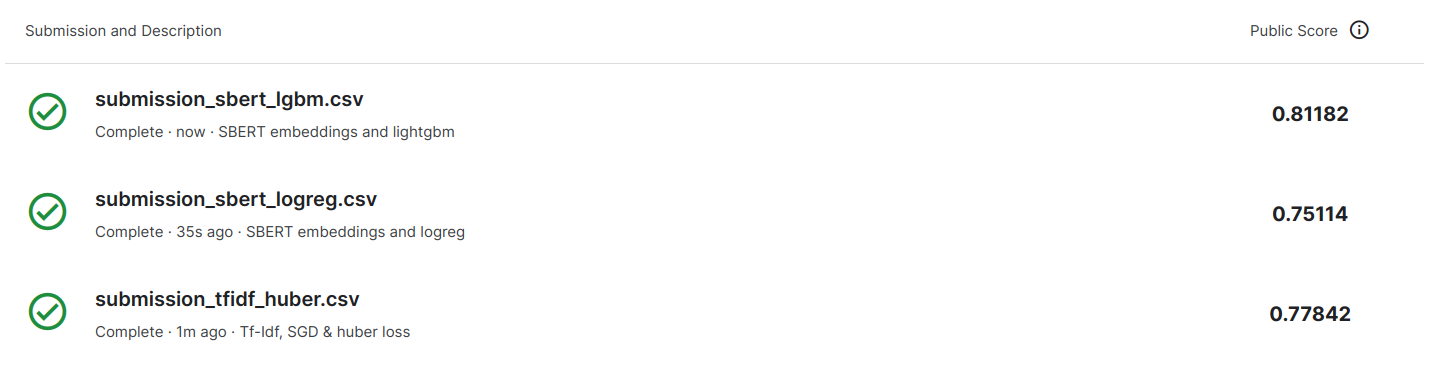

In [217]:
submission_results = {
    "sbert_lgbm": 0.81182,
    "tfidf_hinge": 0.79374,
    "tfidf_huber": 0.77842,
    "sbert_huber": 0.75114
}
submission_results = pd.Series(submission_results)
submission_results.name = "submission"

In [218]:
results = pd.merge(results, submission_results, left_on='experiment', right_index=True)

In [219]:
results

,experiment,f1_avg,f1_std,f1_min,f1_max,f1_lower_bound_estimation,f1_higher_bound_estimation,submission
3,sbert_lgbm,0.8048,0.0047,0.7994,0.8128,0.7907,0.8189,0.81182
1,tfidf_hinge,0.7838,0.0114,0.7691,0.8052,0.7496,0.8180,0.79374
0,tfidf_huber,0.7682,0.0092,0.7517,0.7806,0.7406,0.7958,0.77842
2,sbert_huber,0.7318,0.0191,0.6984,0.7601,0.6745,0.7891,0.75114


In [220]:
(results['f1_lower_bound_estimation'] <= results['submission']) & (results['submission'] <= results['f1_higher_bound_estimation'])

3    True
1    True
0    True
2    True
dtype: bool

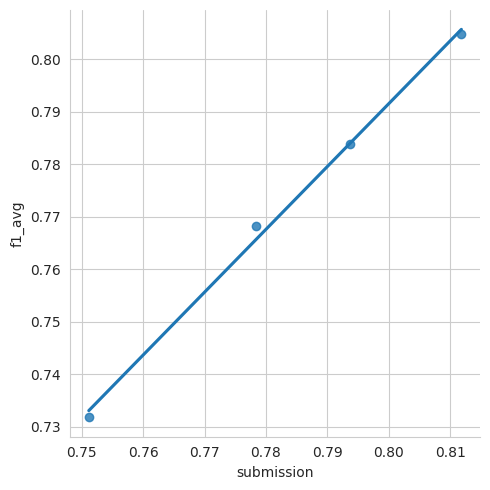

In [221]:
sns.set_style("whitegrid")
sns.lmplot(data=results, y='f1_avg', x='submission', ci=None)

Conclusions
1. all submission scores lie in the correspondent confidence intervals, retrieved on train cross-validation 
2. increments in average cv score highly correlate with increments in submission scores (clear linear dependence)

### Adversarial validation

In [10]:
df_twitter["train"] = True
df_twitter_unseen_test["train"] = False
df_adversarial = pd.concat([df_twitter[['text', 'train']], df_twitter_unseen_test[['text', 'train']]])

In [11]:
df_train_adv, df_test_adv = train_test_split(
    df_adversarial, test_size=0.3, random_state=42, stratify=df_adversarial["train"]
)

In [12]:
adv_probas = {}
for model_name, model in models.items():
    # prediction probabilities are not available for hinge loss
    if model_name == "tfidf_hinge":
        continue
    model.fit(df_train_adv.text, df_train_adv.train)
    probas = model.predict_proba(df_test_adv.text)[:, 1]
    adv_probas[model_name] = probas
    # print(f"{model_name} adv roc_auc: {roc_auc_score(df_test_adv.train, probas)}")

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Batches: 0it [00:00, ?it/s]

[LightGBM] [Info] Number of positive: 5329, number of negative: 2284
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 7613, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699987 -> initscore=0.847235
[LightGBM] [Info] Start training from score 0.847235


Batches: 0it [00:00, ?it/s]

In [13]:
import matplotlib.pyplot as plt

tfidf_huber adv roc_auc: 0.48061390782617097
sbert_huber adv roc_auc: 0.5017121817358933
sbert_lgbm adv roc_auc: 0.48694005821015396


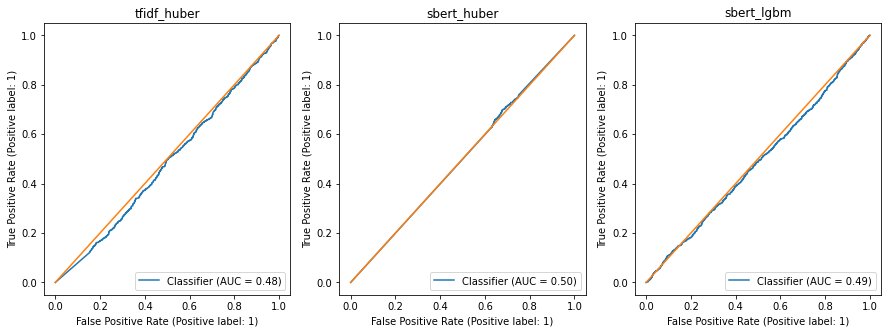

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (model_name, probas) in enumerate(adv_probas.items()):
    print(f"{model_name} adv roc_auc: {roc_auc_score(df_test_adv.train, probas)}")
    RocCurveDisplay.from_predictions(df_test_adv.train, probas, ax=axs[i])
    axs[i].set_title(model_name)
    axs[i].plot(np.linspace(0,1, 100), np.linspace(0, 1, 100))

## Part 2. CommonLit Summaries

In [22]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import lightgbm as lgb
import seaborn as sns
import os
from tqdm.notebook import tqdm

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, RocCurveDisplay 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

### Load data

In [5]:
dir = "../data/"
# dir = "/kaggle/input/"
prompts_train = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/prompts_train.csv"))
summaries_train = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/summaries_train.csv"))

In [6]:
df_commonlit = pd.merge(prompts_train, summaries_train, on='prompt_id')

In [7]:
df_commonlit

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886
...,...,...,...,...,...,...,...,...
7160,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",ff37545b2805,"In paragraph two, they would use pickle meat a...",1.520355,-0.292990
7161,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",ff4ed38ef099,"in the first paragraph it says ""either can it...",-1.204574,-1.169784
7162,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",ff53b94f7ce0,They would have piles of filthy meat on the fl...,0.328739,-1.053294
7163,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",ff7c7e70df07,They used all sorts of chemical concoctions to...,0.205683,0.380538


### Models

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GroupKFold, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import nltk

We will use the following four models:
- Bag of Words with Ridge regression
- Tf-Idf with Ridge regression
- SBERT encodings with Ridge regression
- SBERT encodings with LightGBM

For simplicity, we will use the same model for both wording and content targets

In [9]:
# for effective sentence embedding during cross-validation with Pipeline
cached_embeddings = {}
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

/home/evgeniy/.local/bin/miniconda3/envs/iasa_nlp_env/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() > 0


In [51]:
def preprocess_general(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t.isalpha()]
    return " ".join(tokens)

In [59]:
def sbert_encode_with_cache(series):
    new_texts = series[~series.isin(cached_embeddings.keys())].unique()
    if new_texts.size > 0:
        cached_embeddings.update(
            dict(zip(
                new_texts, 
                sentence_model.encode(new_texts, show_progress_bar=True)
            ))
        )

    embeddings = series.map(cached_embeddings).apply(pd.Series)
    return embeddings

In [53]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
def sbert_encode(series):
    return sentence_model.apply(preprocess_general).encode(series.to_numpy(), convert_to_tensor=True, show_progress_bar=True).detach().cpu().numpy()

In [54]:
models = { 
    "bow_ridge": Pipeline([
        ('vectorize', ColumnTransformer([
            ('prompt', CountVectorizer(ngram_range=(1, 2), min_df=5), 'prompt_text'),
            ('summary', CountVectorizer(ngram_range=(1, 2), min_df=5), 'text')
        ], remainder="drop")),
        ('regressor', Ridge(alpha=1e4, random_state=42))
    ]),
    "tfidf_ridge": Pipeline([
        ('vectorize', ColumnTransformer([
            ('prompt', TfidfVectorizer(ngram_range=(1, 2), min_df=5), 'prompt_text'),
            ('summary', TfidfVectorizer(ngram_range=(1, 2), min_df=5), 'text')
        ], remainder="drop")),
        ('regressor', Ridge(alpha=1e4, random_state=42))
    ]),
    "sbert_ridge": Pipeline([
        ('vectorize', ColumnTransformer([
            ('prompt', FunctionTransformer(sbert_encode_with_cache), 'prompt_text'),
            ('summary', FunctionTransformer(sbert_encode_with_cache), 'text')
        ], remainder="drop")),
        ('regressor', Ridge(alpha=1e4, random_state=42))
    ]),
    "sbert_lgbm": Pipeline([
        ('vectorize', ColumnTransformer([
            ('prompt', FunctionTransformer(sbert_encode_with_cache), 'prompt_text'),
            ('summary', FunctionTransformer(sbert_encode_with_cache), 'text')
        ], remainder="drop")),
        ('regressor', lgb.LGBMRegressor(random_state=42))
    ])
}

In [ ]:
results = []

for model_name, model in tqdm(models.items()):
    scores = []
    cv = KFold(n_splits=4, shuffle=True, random_state=42)
    rmse_wording = -cross_val_score(model, df_commonlit, df_commonlit['wording'], cv=cv, scoring="neg_root_mean_squared_error")
    rmse_content = -cross_val_score(model, df_commonlit, df_commonlit['content'], cv=cv, scoring="neg_root_mean_squared_error")

    mcrmse = np.mean([rmse_content, rmse_wording])
        
    results.append({
        'experiment': model_name,
        'rmse_wording': rmse_wording.mean(),
        'rmse_content': rmse_content.mean(),
        'mcrmse': mcrmse
    })
    
results_kfold = pd.DataFrame(results).sort_values('mcrmse', ascending=False)

In [ ]:
results = []

for model_name, model in tqdm(models.items()):
    scores = []
    cv = GroupKFold(n_splits=4)
    rmse_wording = -cross_val_score(model, df_commonlit, df_commonlit['wording'], cv=cv, groups=df_commonlit['prompt_id'], scoring="neg_root_mean_squared_error")
    rmse_content = -cross_val_score(model, df_commonlit, df_commonlit['content'], cv=cv, groups=df_commonlit['prompt_id'], scoring="neg_root_mean_squared_error")

    mcrmse = np.mean([rmse_content, rmse_wording])
        
    results.append({
        'experiment': model_name,
        'rmse_wording': rmse_wording.mean(),
        'rmse_content': rmse_content.mean(),
        'mcrmse': mcrmse
    })
    
results_group_kfold = pd.DataFrame(results).sort_values('mcrmse', ascending=False)

In [60]:
results_kfold

,experiment,rmse_wording,rmse_content,mcrmse
1,tfidf_ridge,1.030059,1.040973,1.035516
2,sbert_ridge,1.027362,1.040250,1.033806
0,bow_ridge,0.760027,0.600752,0.680389
3,sbert_lgbm,0.700983,0.526514,0.613748


In [61]:
results_group_kfold

,experiment,rmse_wording,rmse_content,mcrmse
2,sbert_ridge,1.077697,1.055219,1.066458
1,tfidf_ridge,1.075394,1.053805,1.064599
3,sbert_lgbm,1.051063,1.006999,1.029031
0,bow_ridge,0.959655,0.747199,0.853427


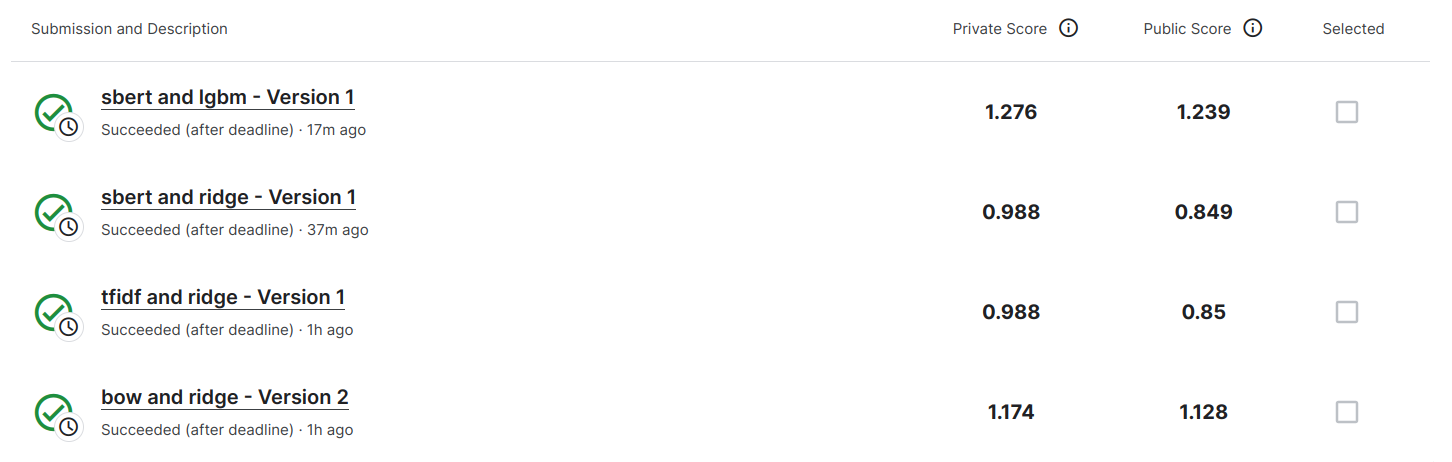

In [68]:
results = pd.DataFrame({
    "experiment": ["bow_ridge", "tfidf_ridge", "sbert_ridge", "sbert_lgbm"], 
    "LB_public": [1.128, 0.85, 0.849, 1.239],
    "LB_private": [1.174, 0.988, 0.988, 1.276]
})
results["kfold"] = results_kfold['mcrmse']
results['group_fold'] = results_group_kfold['mcrmse']

In [72]:
results

,experiment,LB_public,LB_private,kfold,group_fold
0,bow_ridge,1.128,1.174,0.680389,0.853427
1,tfidf_ridge,0.850,0.988,1.035516,1.064599
2,sbert_ridge,0.849,0.988,1.033806,1.066458
3,sbert_lgbm,1.239,1.276,0.613748,1.029031


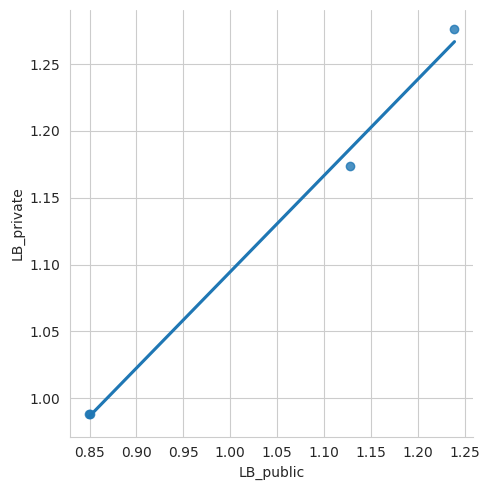

In [74]:
sns.lmplot(data=results, y='LB_private', x='LB_public', ci=None)

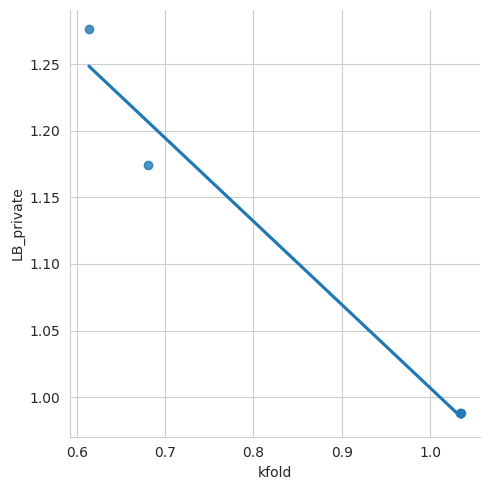

In [75]:
sns.lmplot(data=results, y='LB_private', x='kfold', ci=None)

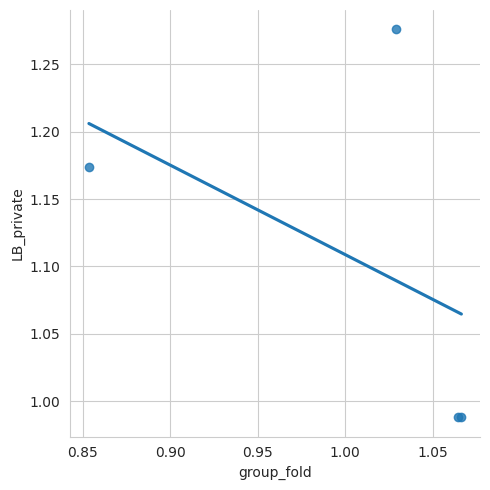

In [76]:
sns.lmplot(data=results, y='LB_private', x='group_fold', ci=None)

### Summary

Although public and private LB metrics don't fully coincide, they have quite good linear correlation. Expectedly, KFold cross-validation didn't show good correlation with LB, because LB score is calculated on the previously unseen prompts, while KFold train and tests summaries on the same prompts. There we have even significant negative correlation.
What's more interesting is that GroupKFold cross-validation didn't manage to represent LB score too. I suspect it may be due to the choice of prompts for training dataset by competition's host -- although in the competition overview it's mentioned that prompts are taken from the assignments for grades 3-12, some kagglers in discussions digged that train prompts are taken from grades 7, 9, 9, 11. Thus there is no prompts from grades 3-6 in the training, but there are such in the public and private LB, what can be the cause of such bad CV representativity.